# UAB - Aprenentatge Computacional 


## Cas Kaggle 

[Enllaç al repositori de GitHub] (https://github.com/danielalcover1/APC-Cas-Kaggle)

[Enllaç a la pàgina de Kaggle de la base de dades] (https://www.kaggle.com/datasets/ruchi798/movies-on-netflix-prime-video-hulu-and-disney)

### Objectius

Els objectius d'aquesta pràctica són:

+ Entendre els diferents atributs de la base de dades.
+ Visualitzar la correlació que els atributs tenen respecte el nostre atribut objectiu.
+ Crear un model classificador sobre la acústica d'una cançó a partir d'altres atributs.

### Introducció

La base de dades consisteix en un conjunt de pel·lícules majoritàriament del segle 21 però també del segle 20.
Cada pel·lícula té marcat en quina de les 4 plataformes de Streaming principals hi és.

Els atributs de la base de dades son:
* RowId: número de la fila dins la base de dades.
* Id.
* Títol.
* Any: any de sortida.
* Edat: és la edat mínima recomanada.
* Rotten Tomatoes: valoració sobre 100 feta per usuaris i experts a la web Rotten Tomatoes que és reconeguda a nivell mundial.
* Netflix.
* Hulu.
* Prime Video.
* Disney+.

La idea darrere d'aquest dataset i l'estudi explicat a continuació és poder saber a quina plataforma anar quan es vulgui veure una pel·lícula en particular.

En el nostre cas, establirem com a variable objectiu l'anomenada 'Prime Video', sobre la qual crearem diferents models classificadors que siguin capaços de predir si una pel·lícula està a la plataforma o no.

### Llibreries usades

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from numpy import mean,std
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import warnings
import altair as alt
import statistics as st
from prettytable import PrettyTable
import scikitplot as skplt
warnings.filterwarnings('ignore')

## Informació de les dades

### Càrrega del Dataset:

Primer carregarem el dataset i farem un estudi de les dades per entendre-les en profunditat. Si és necessari es farà una neteja de les dades.

In [2]:
dataset = "../data/archive/MoviesOnStreamingPlatforms.csv"
dades = pd.read_csv(dataset)

Observant les dades podem veure, a simple vista, que les 3 primeres columnes no aporten cap informació rellevant. Son el nombre de fila, l'id i el títol. Cap de les tres columnes dona cap informació rellevant per l'estudi, així que s'eliminen:

In [3]:
dades.drop(dades.columns[0], inplace = True, axis = 1) #nombre de fila
dades.drop('Title', inplace = True, axis = 1) #títol
dades.head()

,ID,Year,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type
0,1,2019,18+,98/100,1,0,0,0,0
1,2,2016,7+,97/100,1,0,0,0,0
2,3,2020,7+,95/100,1,0,0,0,0
3,4,2001,7+,94/100,1,0,0,0,0
4,5,2018,18+,94/100,1,0,0,0,0


In [4]:
print("files: {}".format(dades.shape[0]))
print("columnes: {}".format(dades.shape[1]))

files: 9515
columnes: 9


Com es pot observar a les 5 files printades d'exemple, el dataset té un id, l'any de sortida de la pel·lícula, el mínim d'edat recomanat, la valoració i a quines plataformes hi és. Equival a 8 columnes significatives, 10 el dataset total.

In [5]:
print(dades.isnull().sum())

ID                    0
Year                  0
Age                4177
Rotten Tomatoes       7
Netflix               0
Hulu                  0
Prime Video           0
Disney+               0
Type                  0
dtype: int64


Com es pot Observar hi ha un gran número de nulls a la columna "Age" i uns pocs a la "Rotten Tomatoes". Els nulls de la segona columna són massa pocs perquè aquests siguin rellevants per l'estudi, però els 4177 nulls de la primera si afectarien gaire als resultats. Per tant, es procedeix a eliminar les files que tinguin null:

In [6]:
dades = dades.dropna(subset=['Age'])
print("files: {}".format(dades.shape[0]))

files: 5338


Ara que ja hem netejat el dataset de nulls, podem veure un exemple de 10 files aleatòries per comprovar les dades:

In [7]:
dades.sample(10)

,ID,Year,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type
5362,5363,2007,13+,61/100,0,0,1,0,0
1036,1037,2019,18+,62/100,1,0,0,0,0
1945,1946,2016,18+,52/100,1,0,0,0,0
4842,4843,2016,13+,73/100,0,0,1,0,0
7717,7718,2015,all,41/100,0,0,1,0,0
6178,6179,2013,7+,52/100,0,0,1,0,0
4020,4021,2019,7+,65/100,0,1,0,0,0
8817,8818,1999,all,69/100,0,0,0,1,0
7074,7075,2011,13+,45/100,0,0,1,0,0
6892,6893,1979,all,46/100,0,0,1,0,0


L'última columna correspon al tipus: pel·lícula o sèrie de televisió. És un atribut categòric i a simple vista sembla que no aporta gaire informació. Però per assegurar-nos extraurem la quantitat de valors '1' i '0':

In [8]:
dades['Type'].value_counts()

0    5338
Name: Type, dtype: int64

Podem veure que totes les files tenen el mateix valor que és 0, marcant que totes son pelicules, per tant, no aporta cap informació rellevant i la podem eliminar:

In [9]:
dades.drop('Type', inplace = True, axis = 1) #tipus

## Anàlisi de la informació

Ara que ja s'ha fet una primera neteja bàsica del dataset i s'ha estudiat bé les dades ja podem començar amb l'anàlisi.

Primer hi ha la columna de l'any. Treure una gràfica de les dades ens pot ajudar a saber en quins anys van sortir més pelicules. 
També, hem vist que les columnes que representen si una pel·lícula hi és o no en una plataforma de Streaming, són categòriques, és a dir, només poden tenir 2 valors: 0 o 1. Per tant, podem extreure gràfiques de la proporció dels 2 valors que té cada plataforma:

array([[<AxesSubplot: title={'center': 'ID'}>,
        <AxesSubplot: title={'center': 'Year'}>],
       [<AxesSubplot: title={'center': 'Netflix'}>,
        <AxesSubplot: title={'center': 'Hulu'}>],
       [<AxesSubplot: title={'center': 'Prime Video'}>,
        <AxesSubplot: title={'center': 'Disney+'}>]], dtype=object)

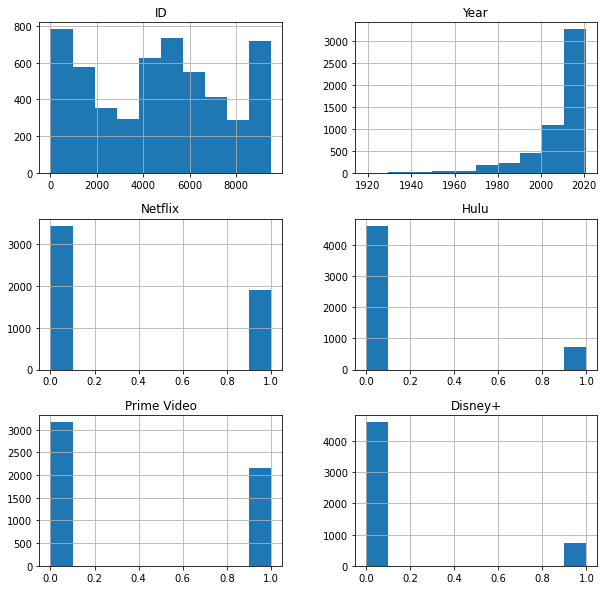

In [10]:
dades.hist(figsize=(10,10))

Amb aquestes gràfiques podem observar que la majoria de pel·lícules són del segle 21, sobretot de la segona dècada d'aquest. I també podem apreciar la quantitat de pel·lícules que té cada plataforma i així poder comparar-les pel que fa a quantitat.

Netflix, per exemple, té ~1900 pel·lícules de les 5338 totals. Per tant, un ~35% del total.
En canvi, Hulu i Disney+ tenen ~900 contra 5338 pel·lícules totals. Doncs, té ~17%.
Es veu ben clar que la plataforma amb més pel·lícules és Prime Video amb ~2150. Té un ~40%. Just per aquesta raó ha estat escollit com l'atribut objectiu, ja que té els valors més repartits, com a resultat, la predicció podria ser més difícil que amb la resta.

Podem concloure que hi ha 2 plataformes majoritàries quant a quantitat de pel·lícules i hi ha 2 clarament inferiors.

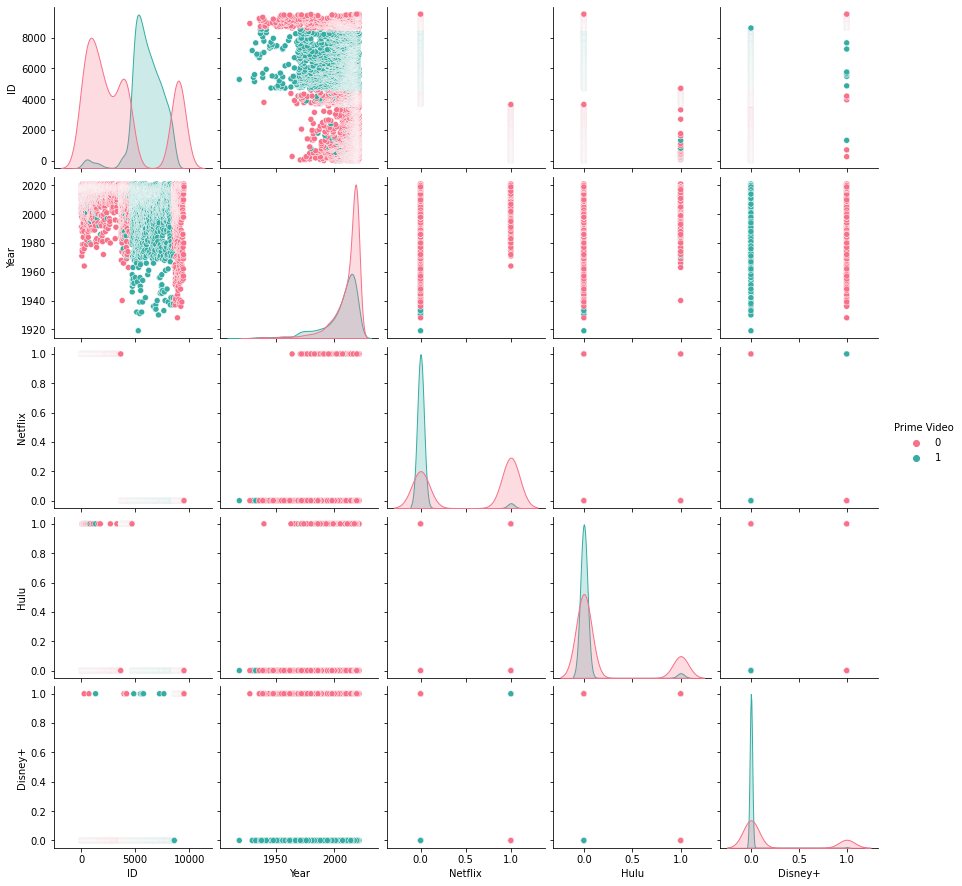

In [11]:
sns.pairplot(dades, hue='Prime Video', diag_kind = "kde", kind = "scatter", palette = "husl")

### Normalització de les Dades

Per poder normalitzar les dades cal eliminar la columna de títol, ja que no dona informació rellevant per l'estudi i, a més, només es poden normalitzar valors númerics.

També cal modificar la columna de valoració "Rotten Tomatoes" i la columna d'edat "Age", perquè estan en string i en formats no vàlids.

Primer cal eliminar caràcters innecessaris de les columnes. En el cas de la valoració, els valors estan en format "x/100", per tant, cal eliminar "/100". En el cas de l'edat tenen un "+" al final que també cal eliminar:

In [12]:
dades_copy=dades.copy()
dades_copy.loc[:, 'Rotten Tomatoes'] = dades_copy.loc[:, 'Rotten Tomatoes'].str.split("/").str[0]
dades_copy.loc[:, 'Rotten Tomatoes'] = pd.to_numeric(dades_copy.loc[:, 'Rotten Tomatoes'])
dades_copy.loc[:, 'Age'] = dades_copy.loc[:, 'Age'].str.replace("+", "")
dades_copy.loc[:, 'Age'] = dades_copy.loc[:, 'Age'].str.replace("all", "0")
dades_copy.loc[:, 'Age'] = pd.to_numeric(dades_copy.loc[:, 'Age'])

Després d'eliminar els atributs string i formatar altres, podem veure unes estadístiques dels atributs restants, que són tots numèrics:

In [13]:
print("Estadístiques dels atributs numèrics de la BD:")
dades_copy.describe()

Estadístiques dels atributs numèrics de la BD:


,ID,Year,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+
count,5338.000000,5338.000000,5338.000000,5338.000000,5338.000000,5338.000000,5338.000000,5338.000000
mean,4609.876546,2008.515362,12.361933,58.465155,0.355564,0.134507,0.405583,0.135819
std,2860.315830,14.275385,6.338357,12.654353,0.478729,0.341229,0.491050,0.342628
min,1.000000,1919.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,1841.000000,2005.000000,7.000000,49.000000,0.000000,0.000000,0.000000,0.000000
50%,4798.500000,2014.000000,13.000000,58.000000,0.000000,0.000000,0.000000,0.000000
75%,6842.750000,2018.000000,18.000000,67.000000,1.000000,0.000000,1.000000,0.000000
max,9515.000000,2021.000000,18.000000,98.000000,1.000000,1.000000,1.000000,1.000000


Amb aquestes estadístiques podem veure gaire informació dels diferents atributs. Per exemple, veiem quins anys van sortir més pel·lícules, o la tònica general quant a edat recomanada al món cinematogràfic actual.

Un altre informació gaire important que proporcionen aquestes estadístiques és que no hi ha outliers en aquest dataset. No hi ha cap valor fora dels rangs vàlids.

<AxesSubplot: >

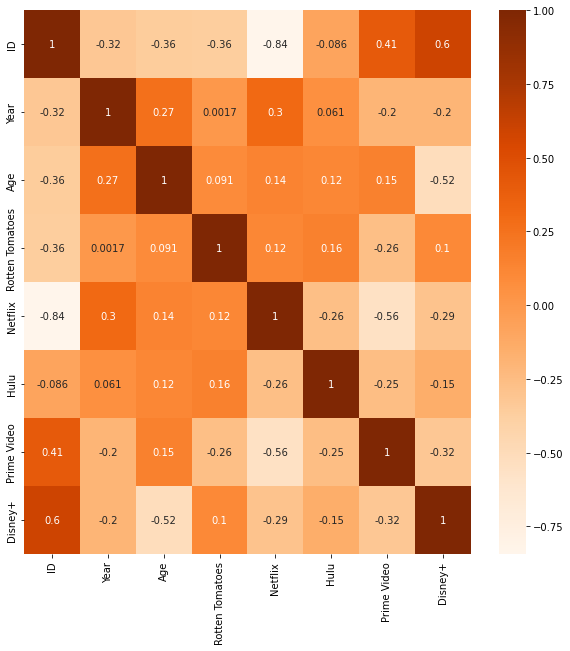

In [14]:
correlacion= dades_copy.corr()
fig , ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
sns.heatmap(correlacion,annot=True,cmap="Oranges")

En la matriu anterior podem veure que els atributs vàlids amb més correlació l'atrbiut objectiu son any i edat, per tant, es tindrà en compte a l'hora de crear el nostre model.

A continuació es fa la normalització de les dades:

In [15]:
dades_copy=dades_copy.apply(lambda x: (x-x.mean())/ x.std(), axis=0)
dades_norm=(dades_copy - dades_copy.min()) / ( dades_copy.max() - dades_copy.min())

Ara que ja tenim les dades preparades, podem començar a preparar les dades per al nostre model regressor. Per fer-ho, dividirem la nostra base de dades entre el set d'entrenament i el set de test, utilitzant el 70% per l'entrenament i el 30% restant per efectuar el test:

In [16]:
y = dades_norm['Prime Video']
x = dades_norm.drop(columns = ['Prime Video'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=25)

## Model learning

Per al nostre estudi, necessitarem utilitzar models classificadors. En el nostre cas utilitzarem els models de regressió logística, decision tree, random forest, i de K-nearest neighbours per a la generació dels nostres models.

Primer creem les instàncies de cadascun dels models:

In [17]:
logisticRegression = LogisticRegression(C=0.010,fit_intercept=True, penalty='l2',tol=0.001)
SVM = SVC()
randomForest = RandomForestClassifier(n_estimators=50)

models = [logisticRegression, SVM, randomForest]


A continuació, ve el bucle principal que executa els 3 models diferents amb les dades normalitzades. No només executa els models, també guarda els informes generats després de la seva execució per a poder estudiar-los:

In [18]:
matriu_confusio = []
precisio = []
metriques = []

for model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    prec = round(accuracy_score(y_test, predictions)*100)
    model_cm = confusion_matrix(y_test.values, predictions)
    informe = classification_report(y_test, predictions)
    
    matriu_confusio.append(model_cm)
    precisio.append(prec)
    metriques.append(informe)

Finalment només cal mostrar els resultats de precisió dels 3 models. Utilitzarem pretty_table: 

In [19]:
precisio_models = PrettyTable()

precisio_models.add_column("Model", ['logisticRegression', 'SVM', 'randomForest'])
precisio_models.add_column("Precisió", precisio)
print(precisio_models)

+--------------------+----------+
|       Model        | Precisió |
+--------------------+----------+
| logisticRegression |    98    |
|        SVM         |    98    |
|    randomForest    |    97    |
+--------------------+----------+


Podem apreciar que els 3 models diferents escollits tenen una precisió en la predicció molt alta.

In [20]:
def plot_confusionMatrix(matriu_confusio):
    plt.figure(figsize=(15,12))
    
    plt.subplot(2,2,1)
    plt.title("Logistic Regression")
    sns.heatmap(matriu_confusio[0], annot = True, cmap="OrRd", fmt='.0f', cbar=False);
    
    plt.subplot(2,2,2)
    plt.title("SVM")
    sns.heatmap(matriu_confusio[1], annot = True, cmap="OrRd", fmt='.0f',cbar=False);
    
    plt.subplot(2,2,3)
    plt.title("Random Forest")
    sns.heatmap(matriu_confusio[2], annot = True, cmap="OrRd", fmt='.0f',cbar=False);
    
    plt.show()   

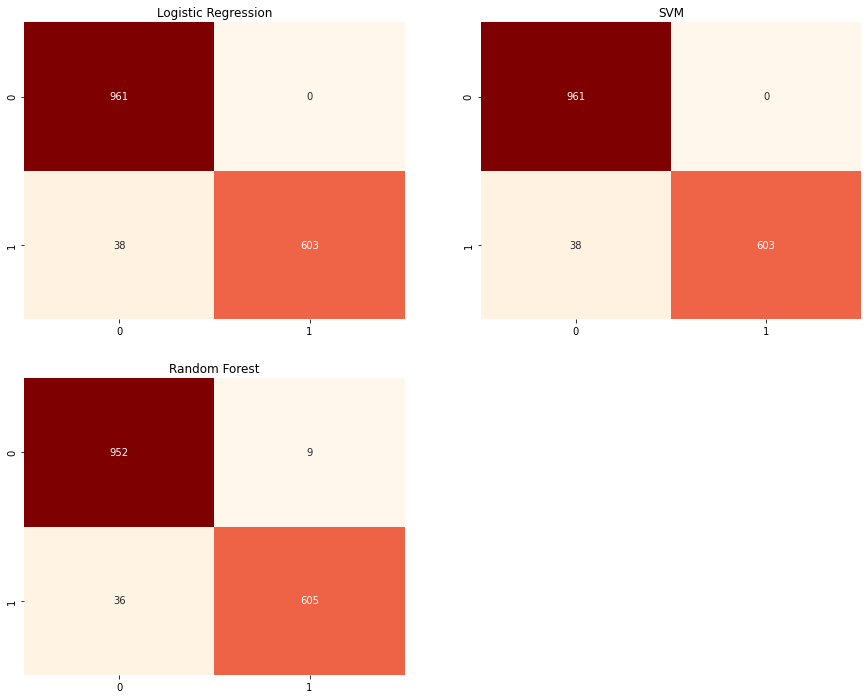

In [21]:
plot_confusionMatrix(matriu_confusio)

Les matrius anteriors ens ajuden a saber el nombre de falsos/vertaders positius o negatius que hi hagi hagut de la següent manera:
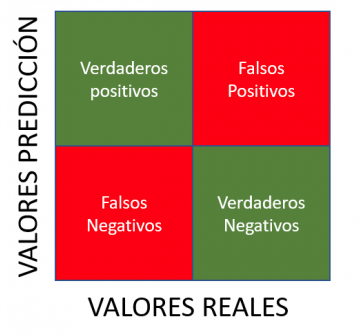

Com es pot observar hi ha un nombre de resultats erronis molt baix que va amb concordança amb la alta precisió obtinguda.

## Corbes ROC

Per observar el rendiment dels diferents models utilitzats podem utilitzar les corbes ROC. Aquestes indiquen la capacitat dels models de difeenciar entre les classes, en el nostre cas si hi és o no a la plataforma Prime Video:

In [22]:
logisticRegression_prob = logisticRegression.predict_proba(X_test)
randomForest_prob = randomForest.predict_proba(X_test)

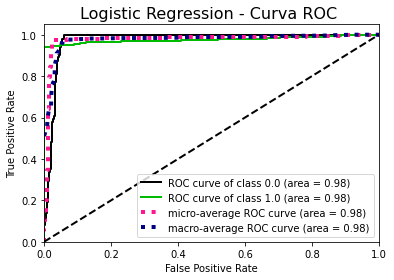

In [23]:

skplt.metrics.plot_roc(y_test, logisticRegression_prob) 
plt.title("Logistic Regression - Curva ROC ", fontsize=16)
plt.show()

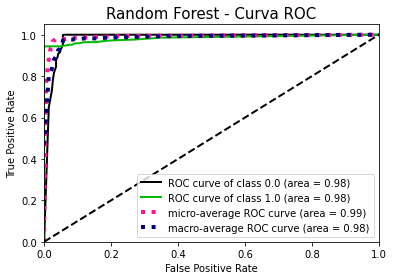

In [24]:
skplt.metrics.plot_roc(y_test, randomForest_prob) 
plt.title("Random Forest - Curva ROC", fontsize=15)
plt.show()

In [25]:
print("AUC de Logistic Regression: ", round((roc_auc_score(y_test, logisticRegression_prob[:,1], multi_class='ovr')),2))
print("AUC de Random Forest: ", round((roc_auc_score(y_test, randomForest_prob[:,1], multi_class='ovr')),2))

AUC de Logistic Regression:  0.98
AUC de Random Forest:  0.98


Com ja ha mostrat la precisió anteriorment, els models tenen una probabilitat molt alta d'encertar una predicció sobre l'atribut objectiu.

## Mètriques

En el moment que hem executat els models, hem guardat els informes, a continuació les mostrem.

Regressió Logística:

In [26]:
print(metriques[0])

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       961
         1.0       1.00      0.94      0.97       641

    accuracy                           0.98      1602
   macro avg       0.98      0.97      0.98      1602
weighted avg       0.98      0.98      0.98      1602



SVM:

In [27]:
print(metriques[1])

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       961
         1.0       1.00      0.94      0.97       641

    accuracy                           0.98      1602
   macro avg       0.98      0.97      0.98      1602
weighted avg       0.98      0.98      0.98      1602



Random Forest:

In [28]:
print(metriques[2])

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       961
         1.0       0.99      0.94      0.96       641

    accuracy                           0.97      1602
   macro avg       0.97      0.97      0.97      1602
weighted avg       0.97      0.97      0.97      1602



# Conclusions

En aquesta pràctica s'ha après a analitzar una base de dades. Primer he estudiat els atributs i he vist quins són útils per a fer un estudi i quins no tenen cap rellevància. Després en l'àmbit de codi he après a eliminar i modificar els atributs per a ser útils per l'estudi.

Després de fer la neteja de les dades, he vist com utilitzar aquestes dades per predir un valor, que en el meu cas ha estat si una pel·lícula hi és o no en una plataforma de Streaming especifica.

A continuació, he après a com fer servir aquestes dades ja netejades i normalitzades per entrenar uns models i que facin aquestes prediccions.

En el meu cas, els models han donat unes precisions molts semblants. Aquestes han estat gaire elevades.
Ja que les precisions i probabilitats d'una bona predicció han estat molt semblants, podríem escollir qualsevol dels 3 models a usar per a fer prediccions reals.

Per acabar, ha estat una pràctica gaire educativa, he après molt sobre com fer prediccions d'un atribut d'una base de dades i l'ús de diferents models per fer-ho.
A més, la base de dades ha estat gaire interessant, ja que el món cinematogràfic i les plataformes de Streaming em sembla gaire interessant. L'estudi dut a terme també podria arribar a tenir un gran ús perquè, tothom en algun moment vol veure una pel·lícula en particular i quasi mai se sap en quina plataforma hi és disponible.